In [1]:
import os
import sys
import time

import numpy as np

from scipy import stats

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy import table
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import hist as ahist

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [3]:
from IPython import display

In [4]:
import data_loaders
import detectability

# Load ELVIS and GALFA

In [5]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)
first_pair = next(iter(elvii_pairs.values()))

Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/galvis/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [6]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')
first_tree = next(iter(elvii_trees.values()))

Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Hall&Oates


/Users/erik/projects/galvis/data_loaders.py:83: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/galvis/elvis_data/PairedTrees/Zeus&Hera


In [7]:
data_loaders.annotate_z0_from_trees(elvii_pairs, elvii_trees)

# Assume cutoff at Mc~8.5, zre~7... 

In [8]:
fidz_idx = -8
fidz = first_tree['z'][0][fidz_idx]
fidMc = (10**8.5) * u.solMass

fidz

7.097165991902834

In [9]:
mdists_z0_all = {}
mdists_z0_sat = {}
mdists_z0_nsat = {}

z0s_all = []
z0s_sat = []
z0s_nsat = []
zres_all = []
zres_sat = []
zres_nsat = []

for name in elvii_pairs.keys():
    pair = elvii_pairs[name]
    tree = elvii_trees[name]
    
    Mvatreions = tree['Mvir'][:, fidz_idx]
    survived = Mvatreions > fidMc
    
    
    mdists_z0_all[name] = pair['Mvir'][survived]
    lowest_z0_all = mdists_z0_all[name].min()
    mdists_z0_sat[name] = pair['Mvir'][survived&~pair['sat_of_either']]
    lowest_z0_sat = mdists_z0_sat[name].min()
    mdists_z0_nsat[name] = pair['Mvir'][survived&~pair['upIDever_either']]
    lowest_z0_nsat = mdists_z0_nsat[name].min()
    
    zres_all.append(Mvatreions[survived][np.argmin(mdists_z0_all[name])].to(u.solMass).value)
    zres_sat.append(Mvatreions[survived&~pair['sat_of_either']][np.argmin(mdists_z0_sat[name])].to(u.solMass).value)
    zres_nsat.append(Mvatreions[survived&~pair['upIDever_either']][np.argmin(mdists_z0_nsat[name])].to(u.solMass).value)
    z0s_all.append(lowest_z0_all.to(u.solMass).value)
    z0s_sat.append(lowest_z0_sat.to(u.solMass).value)
    z0s_nsat.append(lowest_z0_nsat.to(u.solMass).value)
    
z0s_all = z0s_all*u.solMass
z0s_sat = z0s_sat*u.solMass
z0s_nsat = z0s_nsat*u.solMass

zres_all = zres_all*u.solMass
zres_sat = zres_sat*u.solMass
zres_nsat = zres_nsat*u.solMass

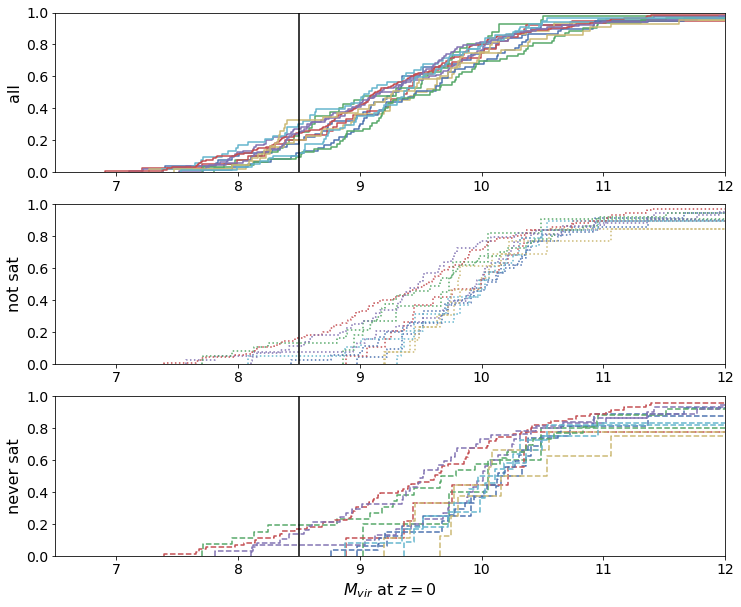

In [10]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

for mdist in mdists_z0_all.values():
    ax1.plot(np.sort(np.log10(mdist/u.solMass)), (np.arange(len(mdist)))/len(mdist), drawstyle='steps')
ax1.set_ylabel('all')
    
for mdist in mdists_z0_sat.values():
    ax2.plot(np.sort(np.log10(mdist/u.solMass)), (np.arange(len(mdist)))/len(mdist), ls=':', drawstyle='steps')
ax2.set_ylabel('not sat')
    
    
for mdist in mdists_z0_nsat.values():
    ax3.plot(np.sort(np.log10(mdist/u.solMass)), (np.arange(len(mdist)))/len(mdist), ls='--', drawstyle='steps')
ax3.set_ylabel('never sat')

for ax in (ax1, ax2, ax3):
    ax.axvline(np.log10(fidMc/u.solMass), c='k')
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(6.5,12)
ax3.set_xlabel(r'$M_{vir}$ at $z=0$')

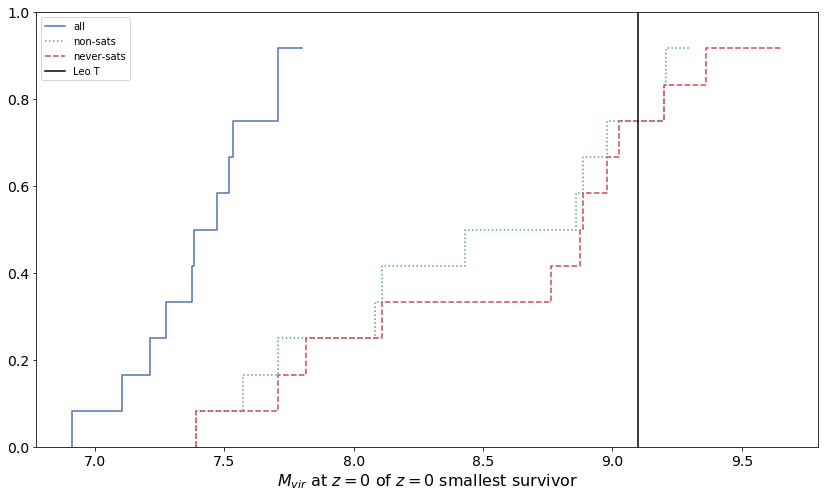

In [11]:
plt.plot(np.log10(np.sort(z0s_all/u.solMass)), np.arange(z0s_all.size)/z0s_all.size, drawstyle='steps', label='all')
plt.plot(np.log10(np.sort(z0s_sat/u.solMass)), np.arange(z0s_sat.size)/z0s_sat.size, drawstyle='steps', ls=':', label='non-sats')
plt.plot(np.log10(np.sort(z0s_nsat/u.solMass)), np.arange(z0s_nsat.size)/z0s_nsat.size, drawstyle='steps', ls='--', label='never-sats')

plt.ylim(0.0, 1.0)

plt.axvline(9.1, color='k', label='Leo T')  #~Leo T at z=0 - see below

plt.xlabel(r'$M_{vir}$ at $z=0$ of $z=0$ smallest survivor')
plt.legend(loc=0);

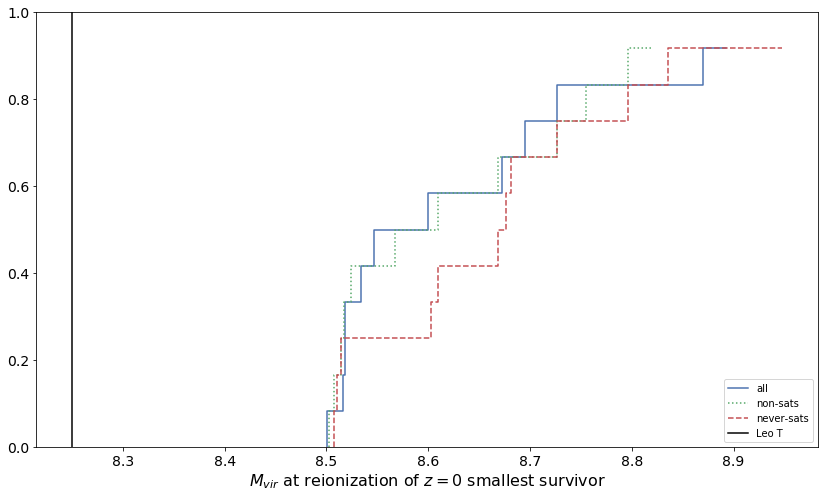

In [12]:
plt.plot(np.log10(np.sort(zres_all/u.solMass)), np.arange(z0s_all.size)/zres_all.size, drawstyle='steps', label='all')
plt.plot(np.log10(np.sort(zres_sat/u.solMass)), np.arange(z0s_sat.size)/zres_sat.size, drawstyle='steps', ls=':', label='non-sats')
plt.plot(np.log10(np.sort(zres_nsat/u.solMass)), np.arange(z0s_nsat.size)/zres_nsat.size, drawstyle='steps', ls='--', label='never-sats')

plt.ylim(0.0, 1.0)

plt.axvline(8.25, color='k', label='Leo T')  #~Leo T at reionization - see below

plt.xlabel(r'$M_{vir}$ at reionization of $z=0$ smallest survivor')
plt.legend(loc=0);

### Figure for paper 

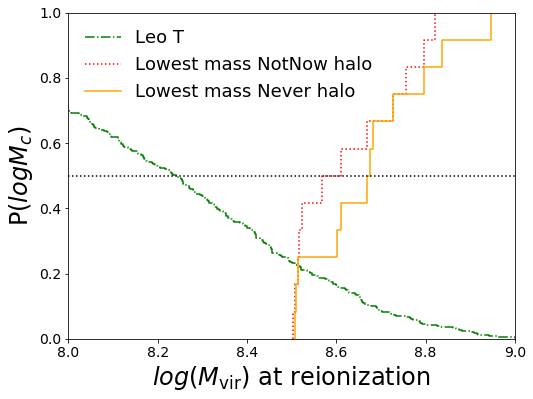

In [76]:
def mass_distr(masses):
    x = np.log10(np.sort(masses/u.solMass))
    y = np.arange(masses.size)/masses.size 
    x = np.append(x, x[-1])
    y = np.append(y, [1])
    return x, y
    
plt.figure(figsize=(8,6))
plt.plot(combined_x, leot_cdf_combined, drawstyle='steps', ls='-.', label='Leo T', c='g')
plt.plot(*mass_distr(zres_sat), drawstyle='steps', ls=':', label='Lowest mass NotNow halo', c='r')
plt.plot(*mass_distr(zres_nsat), drawstyle='steps', ls='-', label='Lowest mass Never halo',c='#ffa500')

plt.xlim(8,9.)
plt.ylim(0.0, 1.0)
plt.axhline(0.5, ls=':', c='k')

plt.xlabel(r'$log(M_{\rm vir})$ at reionization', fontsize=24)
plt.ylabel(r'${\rm P}(log M_c)$', fontsize=24)
plt.legend(loc=0, frameon=False, fontsize=18)

plt.savefig('lowestmassleots.pdf')

# Leo T-ish 

In [13]:
from astropy import modeling

In [14]:
for name, tree in elvii_trees.items():
    for z_re in (6,7,8,9):
        idxzre = np.argmin(np.abs(tree[0]['z']-z_re))    
        elvii_pairs[name]['Mviratz{}'.format(z_re)] = tree['Mvir'][:, idxzre]
        elvii_pairs[name]['Rviratz{}'.format(z_re)] = tree['Rvir'][:, idxzre]
        elvii_pairs[name]['Vmatz{}'.format(z_re)] = tree['Vmax'][:, idxzre]

In [15]:
xs6 = []
ys6 = []
xs9 = []
ys9 = []
for nm, pair in elvii_pairs.items():
    xs6.append(np.log10(pair['Mviratz6'].value))
    ys6.append(np.log10(pair['Rviratz6'].value))
    xs9.append(np.log10(pair['Mviratz9'].value))
    ys9.append(np.log10(pair['Rviratz9'].value))

mv6 = np.concatenate(xs6)
rv6 = np.concatenate(ys6)
mv9 = np.concatenate(xs9)
rv9 = np.concatenate(ys9)

mvs = np.concatenate((mv6, mv9))
rvs = np.concatenate((rv6, rv9))


msk = np.isfinite(mvs)&np.isfinite(rvs)
lmvirtolrvir = modeling.fitting.LinearLSQFitter()(modeling.models.Linear1D(), mvs[msk], rvs[msk])

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


In [16]:
# values from the "Probabilistic Experiments" notebook
lmvirtolrvir =  modeling.models.Linear1D(slope=0.3332146169115156, intercept=-1.4803268453825718)

vtoltvir = lambda v: np.log10((0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)/u.K)
def lmtoltvir(lmvir):
    lrvir = lmvirtolrvir(lmvir)
    vsq = cnst.G * 10**lmvir/10**lrvir * (u.solMass/u.kpc)
    return np.log10((0.6 * cnst.m_p*vsq / 2 / cnst.k_B)/u.K)

In [17]:
detectability.compute_elvis_mgas_bradford_15(elvii_pairs, 'Mstar_preferred')

In [18]:
lmvir0 = []
lmpeak = []
lmstars = []
lmgass = []
for nm, pair in elvii_pairs.items():
    lmvir0.append(np.log10(pair['Mvir']/u.solMass))
    lmpeak.append(np.log10(pair['Mpeak']/u.solMass))
    lmstars.append(np.log10(pair['Mstar_preferred']/u.solMass))
    lmgass.append(np.log10(pair['MHI']/u.solMass))

lmvir0 = np.concatenate(lmvir0)
lmpeak = np.concatenate(lmpeak)
lmstars = np.concatenate(lmstars)
lmgass = np.concatenate(lmgass)

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:1059: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


324

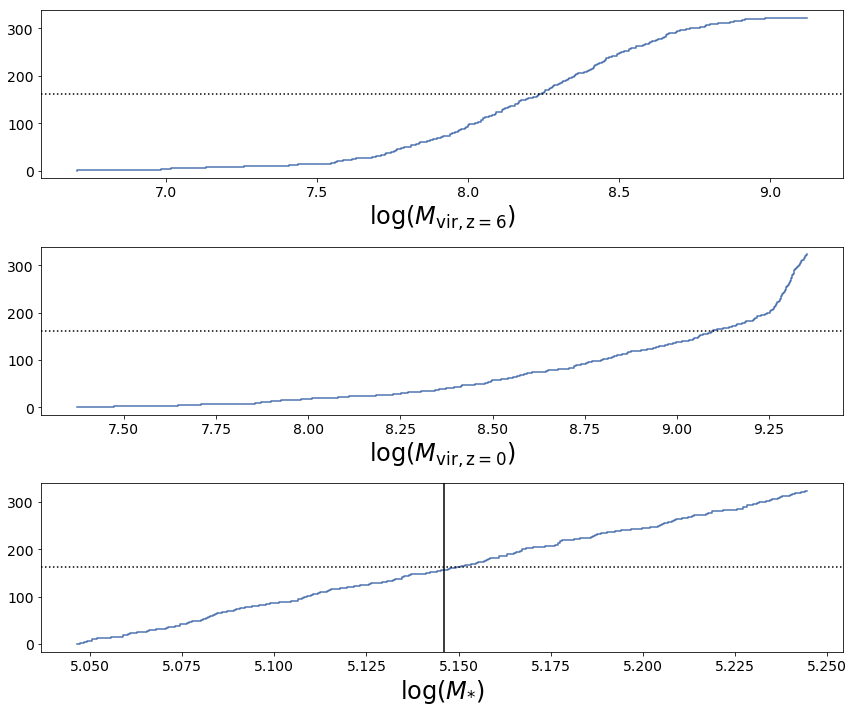

In [19]:
leot_mstar = 1.4e5*u.solMass
leot_mhi = 2.8e5*u.solMass
leot_lmstar = np.log10(leot_mstar/u.solMass)
ltv6 = lmtoltvir(mv6)
ltv9 = lmtoltvir(mv9)
meanlt = ltv6

dlmstar = .1
nearleot = ((leot_lmstar-dlmstar) < lmstars)&(lmstars < (leot_lmstar+dlmstar))

lmat0 = lmvir0[nearleot]
lmnear6 = mv6[nearleot]
lmsnear = lmstars[nearleot]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))


#ax1.hist(lmnear6[np.isfinite(lmnear6)], histtype='step', bins=50)
ax1.plot(np.sort(lmnear6[np.isfinite(lmnear6)]), np.arange(np.sum(np.isfinite(lmnear6))), drawstyle='steps')
ax1.axhline(np.sum(np.isfinite(lmnear6))/2, color='k', ls=':')
ax1.set_xlabel(r'$\log(M_{\rm vir,z=6})$', fontsize=24)

#ax2.hist(lmat0[np.isfinite(lmat0)], histtype='step', bins=50)
ax2.plot(np.sort(lmat0[np.isfinite(lmat0)]), np.arange(np.sum(np.isfinite(lmat0))), drawstyle='steps')
ax2.axhline(np.sum(np.isfinite(lmat0))/2, color='k', ls=':')
ax2.set_xlabel(r'$\log(M_{\rm vir,z=0})$', fontsize=24)

#ax3.hist(lmsnear[np.isfinite(lmsnear)], histtype='step', bins=50)
ax3.plot(np.sort(lmsnear[np.isfinite(lmsnear)]), np.arange(np.sum(np.isfinite(lmsnear))), drawstyle='steps')
ax3.axhline(np.sum(np.isfinite(lmsnear))/2, color='k', ls=':')
ax3.set_xlabel(r'$\log(M_{*})$', fontsize=24)
ax3.axvline(np.log10(leot_mstar/u.solMass), color='k')

plt.tight_layout()

np.sum(nearleot)

In [47]:
lmvg, rmg, zg = np.meshgrid(np.linspace(5.5,9.5, 25), 
                            np.linspace(8,22, 25), 
                            [6, 7, 8, 9])

magtoslice = 19
diff = np.abs(rmg[:,:,0] - magtoslice)
closest = np.min(diff) == diff

assert len(np.unique(rmg[closest])) == 1
rmclosest = rmg[closest][0]

lmclose = lmvg[:,:,0][closest]
ltvclose = lmtoltvir(lmclose)

leot_cdfx = np.sort(lmnear6[np.isfinite(lmnear6)])
leot_cdfy = np.linspace(1, 0, len(lmnear6))
combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)